In [4]:
import numpy as np

def relu(X):
    return np.maximum(0, X)

def softmax(X):
    X = X - np.max(X, axis=1, keepdims=True)
    return np.exp(X) / np.sum(np.exp(X), axis=1, keepdims=True)

def relu_backward(Z, delta):
    delta[Z <= 0] = 0

def cross_entropy_error(y, t):
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + 1e-7)) / batch_size


In [5]:
class FullyConnectedNeuralNetwork():

    def __init__(self, layer_units):
        """
        layer_units : list, 各層のノード数を格納したリスト
        """
        self.n_iter_ = 0
        self.t_ = 0
        self.layer_units = layer_units # 各層のユニット数[5, 4, 3]
        self.n_layers_ = len(layer_units) # 層数（ここでは3）

        # パラメータの初期化
        self.coefs_ = [] # 重み
        self.intercepts_ = [] # バイアス
        for i in range(self.n_layers_ - 1): # affine(ノード間を繋ぐ線群)の数は層数-1になるためこのループ数となる
            coef_init, intercept_init = self._init_coef(layer_units[i],layer_units[i+1]) # 入力側のノード数，出力側のノード数
            self.coefs_.append(coef_init)
            self.intercepts_.append(intercept_init)

        # 勾配の初期化
        self.coef_grads_ = [np.empty((n_in_, n_out_)) for n_in_,n_out_
                                             in zip(layer_units[:-1],layer_units[1:])]
        self.intercept_grads_ = [np.empty(n_out_) for n_out_ in layer_units[1:]]


    def _init_coef(self, n_in, n_out):
        """
        ある層間のパラメータを初期化するメソッド
        n_in : int, 入力側のノード数
        n_out : int, 出力側のノード数
        """
        std = np.sqrt(2/n_in)
        coef_init = np.random.randn(n_in, n_out) * std
        intercept_init = np.zeros(n_out)
        return coef_init, intercept_init


    def _forward(self, activations):
        """
        順伝播処理を行うメソッド
        activations : list, 各層の出力を納めたリスト (affineに対して列数が+1)
            activations[0]は入力データ
            activations[i].shape=(バッチサイズ,ノード数)
        """
        # affineの数を定義（ここでは2）
        affine = [None] * (self.n_layers_ - 1)
        for i in range(self.n_layers_ - 1):

            # アフィン変換
            affine[i] = np.dot(activations[i], self.coefs_[i]) + self.intercepts_[i]

            if (i + 1) == ( self.n_layers_ - 1 ): # rangeはゼロスタートなのでここで+1して調整している
                """
                出力層の場合
                """
                activations[i + 1] = softmax(affine[i]) # 最初の層は入力層なのでi+1になる
            else:
                """
                隠れ層の場合
                """
                activations[i + 1] = relu(affine[i])

        return activations


    def _grad(self, j, activations, deltas):
        """
        各パラメータの勾配を算出するメソッド
        j : int, アフィンの番号
        activations : list, 各層の出力を納めたリスト
        deltas : list, 出力層側から伝わってきた勾配を納めたリスト
        """
        self.coef_grads_[j] = np.dot(activations[j].T,deltas[j])
        self.intercept_grads_[j] = np.sum(deltas[j], axis=0)


    def _backward(self, t, activations):
        """
        逆伝播処理を行うメソッド
        t : array-like, 正解ラベル, t.shape=(バッチサイズ, 出力層ノード数)
        activations : list, 各層の出力を納めたリスト, (レイヤー数, バッチ数, ノード数)
        """
        # deltas: 出力層側から伝わってきた勾配を納めたリスト，(レイヤー数-1, バッチ数, ノード数)
        deltas = [None] * (self.n_layers_ - 1) # affineの数は「層数-1」→ここでは2
        last = self.n_layers_ - 2 # -2にしてるのはゼロスタートだから。つまり[0,1]になるから

        # 交差エントロピー誤差とソフトマックス関数を合わせて勾配を算出
        n_samples = t.shape[0] # サンプル数
        deltas[last] = (activations[-1] - t)/n_samples # 出力層の部分の

        # 出力層の1つ手前のパラメータの勾配を算出
        self._grad(last, activations, deltas)

        # 残りのパラメータの勾配を算出
        for i in range(self.n_layers_ - 2, 0, -1): # "self.n_layers_ - 2"から始まる理由: 出力層側のaffineをこのループの手前で求めているから
            # 入力(activations)の勾配を算出
            deltas[i - 1] = np.dot(deltas[i], self.coefs_[i].T) # 出力層側(deltas)と内積計算するために転置する
            print(f"coefs_[{i}]=\n", self.coefs_[i])
            print(f"deltas[{i}]=\n", deltas[i])
            print(f"deltas[{i-1}]=\n", deltas[i-1])

            # 活性化関数ReLUの勾配を算出
            relu_backward(activations[i], deltas[i - 1]) # 後層のReLUが0だった場合前層のdeltas(損失)が0になるためその判定 ※下記画像参照

            # パラメータの勾配を算出
            self._grad(i-1, activations, deltas)
        print(f"deltas=\n", deltas)
        return


    def _forward_and_back(self, x, t):
        """
        順伝播処理を実行した後、逆伝播処理を実行するメソッド
        x : array-like, 入力データ, x.shape=(バッチサイズ, 入力層ノード数)
        t : array-like, 正解ラベル, t.shape=(バッチサイズ, 出力層ノード数)
        """

        # 入力層に加えて中間層と出力層の出力値を格納する列(None)が追加される
        # →[x, None, None]
        activations = [x] + [None] * (self.n_layers_ - 1) 

        print("init_activations=\n",activations)

        # 順伝播
        activations = self._forward(activations)
        loss = cross_entropy_error(activations[-1], t)

        # 逆伝播
        # self.coef_grads_とself.intercept_grads_に値を格納
        self._backward(t, activations)
        print("activations=\n",activations)

        return loss
    

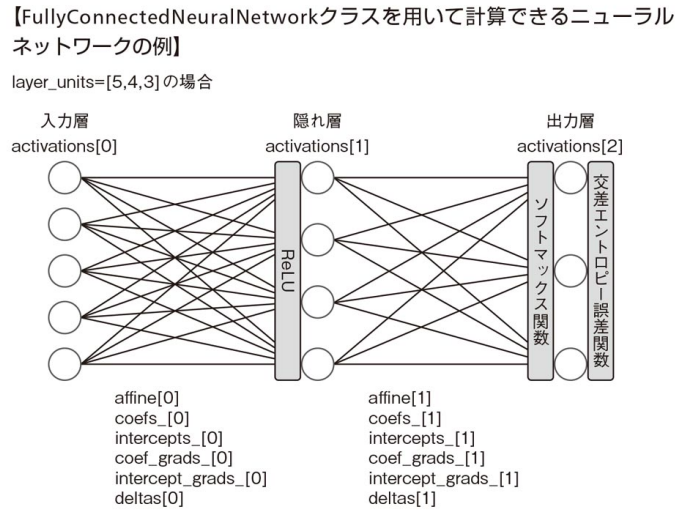
- coefs_[0]: 重み行列を表していて，これは入力と次の層の線形関係を定義する重み係数
- intercepts_[0]: バイアス

In [6]:
if __name__=="__main__":    
    X = np.arange(21).reshape(3,7)
    print("X=\n",X)
    
    t = np.array([[0,1,0],[0,1,0],[1,0,0]]) # 正解ラベル→行数=サンプル数(バッチサイズ)
    print("t=\n",t)

    layer_units=[7,4,3] # 各層のユニット数[入力層，中間層，出力層]

    mp = FullyConnectedNeuralNetwork(layer_units=layer_units)
    loss = mp._forward_and_back(X, t) 
    print("loss=",loss)


X=
 [[ 0  1  2  3  4  5  6]
 [ 7  8  9 10 11 12 13]
 [14 15 16 17 18 19 20]]
t=
 [[0 1 0]
 [0 1 0]
 [1 0 0]]
init_activations=
 [array([[ 0,  1,  2,  3,  4,  5,  6],
       [ 7,  8,  9, 10, 11, 12, 13],
       [14, 15, 16, 17, 18, 19, 20]]), None, None]
coefs_[1]=
 [[ 0.77314497 -0.76056341 -0.5830329 ]
 [-0.07877726 -1.99442314 -0.11271616]
 [-0.75020207 -0.31833711 -1.52607888]
 [-0.36137066 -0.8488297   0.47734711]]
deltas[1]=
 [[ 3.31258051e-01 -3.31458413e-01  2.00361673e-04]
 [ 3.33333324e-01 -3.33333333e-01  9.54117881e-09]
 [-4.51490697e-13  2.53961562e-28  4.51520157e-13]]
deltas[0]=
 [[ 5.08088822e-01  6.34950142e-01 -1.43300733e-01  1.61740445e-01]
 [ 5.11236117e-01  6.38548625e-01 -1.43954997e-01  1.62486353e-01]
 [-6.12318869e-13 -1.53264160e-14 -3.50346115e-13  3.78687334e-13]]
deltas=
 [array([[ 5.08088822e-01,  6.34950142e-01, -1.43300733e-01,
         1.61740445e-01],
       [ 5.11236117e-01,  6.38548625e-01, -1.43954997e-01,
         1.62486353e-01],
       [-6.123188